In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir, unzip_data

### Retrieve data

In [2]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [3]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [4]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMAGE_SHAPE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)


test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMAGE_SHAPE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)                                                                

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Model 0: Building a transfer learning model using the Keras Functional API 

In [5]:

base_model = tf.keras.applications.EfficientNetV2B0( include_top=False) #Custom Dense layer on the top)

# Freeze the base model
base_model.trainable = False

# Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), # EfficientNet have rescaling build in
                               name="input_layer") 

# Pass the input to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# Average pool the output of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# Create the outputs activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_0  = tf.keras.Model(inputs, outputs)


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [6]:
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [7]:
history = model_0.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=test_data)

Epoch 1/5
24/24 [==============================] - 9s 123ms/step - loss: 1.9052 - accuracy: 0.4107 - val_loss: 1.3330 - val_accuracy: 0.7420
Epoch 2/5
24/24 [==============================] - 2s 93ms/step - loss: 1.1569 - accuracy: 0.7600 - val_loss: 0.8968 - val_accuracy: 0.8176
Epoch 3/5
24/24 [==============================] - 2s 93ms/step - loss: 0.8378 - accuracy: 0.8133 - val_loss: 0.7154 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 2s 92ms/step - loss: 0.6872 - accuracy: 0.8467 - val_loss: 0.6219 - val_accuracy: 0.8524
Epoch 5/5
24/24 [==============================] - 2s 93ms/step - loss: 0.5996 - accuracy: 0.8693 - val_loss: 0.5623 - val_accuracy: 0.8632


In [8]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [9]:
# How about gettinf a summury
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


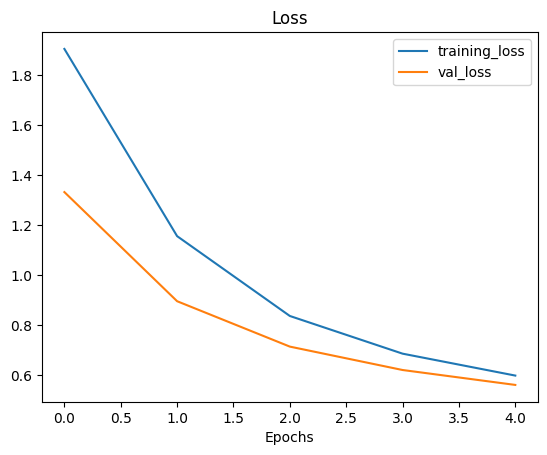

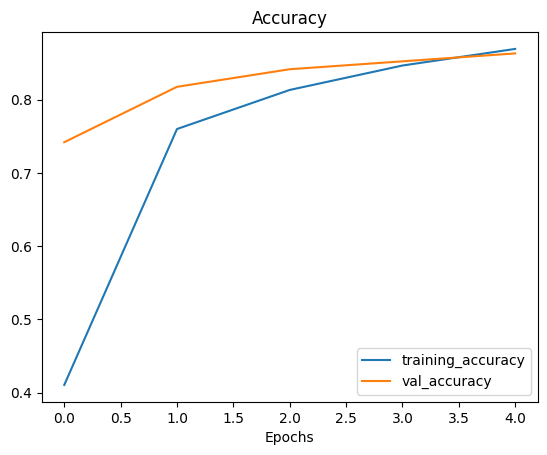

In [10]:
plot_loss_curves(history=history)

### Getting a feature vector fbrom a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2d, it turns into (None, 1280).


In [11]:
# Define the input shape
input_shape = (1, 4, 4, 3)
# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [12]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

### Running a series of transfer learning experiments

1. `model_1` - use feature extraction transfer learning with
 1 % of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10%
of the training with data augmentation
3. `model_3` - use fine-tuning transer learning on 10% of the training
data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the taining 
data with data augmentation

> ***Note:*** throught all experiments the same test dataset will be used to 
evaluate our model... this ensures consistency across evaluation metrics.

In [13]:
# Create training and test dirs
unzip_data("10_food_classes_1_percent.zip")
train_dir_1_percent = "10_food_classes_10_percent/train"
train_dir = "10_food_classes_10_percent/test"

In [14]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [15]:
# Setup data loaders
IMAGE_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMAGE_SIZE,
                                                                           batch_size=BATCH_SIZE)
                                                                    
train_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE)                                                                    

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation 


In [16]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras

# Create data augmentatuin stage with horizontal flipping, rotations, zooms, ect
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255)
], name="data_augmentation")

### Visualize our data augmentation layer

10_food_classes_1_percent/train/pizza/3478964.jpg


Text(0.5, 1.0, 'Augmented random image from pizza')

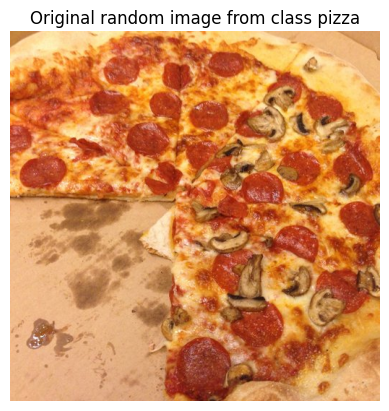

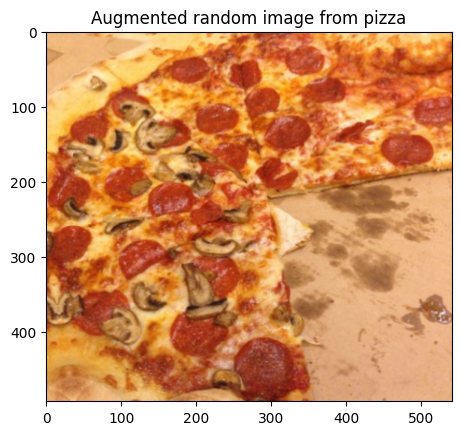

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)
print(random_image_path)

augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training = True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from {target_class}")

### Model 1: Feature extraction transfer learning in 1% if the data with data augmentation

In [29]:
tf.random.set_seed(42)
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240722-204247
Epoch 1/5
24/24 [==============================] - 8s 156ms/step - loss: 2.0118 - accuracy: 0.3613 - val_loss: 1.4706 - val_accuracy: 0.6743
Epoch 2/5
24/24 [==============================] - 3s 131ms/step - loss: 1.3968 - accuracy: 0.6387 - val_loss: 1.0520 - val_accuracy: 0.7401
Epoch 3/5
24/24 [==============================] - 3s 129ms/step - loss: 1.1150 - accuracy: 0.7160 - val_loss: 0.8650 - val_accuracy: 0.7845
Epoch 4/5
24/24 [==============================] - 3s 126ms/step - loss: 0.9244 - accuracy: 0.7733 - val_loss: 0.7344 - val_accuracy: 0.8092
Epoch 5/5
24/24 [==============================] - 3s 125ms/step - loss: 0.8480 - accuracy: 0.7920 - val_loss: 0.6714 - val_accuracy: 0.8026


In [26]:
# checkout mode summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [30]:
# Evaluate on the full dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 2s 21ms/step - loss: 0.6648 - accuracy: 0.8160


[0.6648469567298889, 0.8159999847412109]

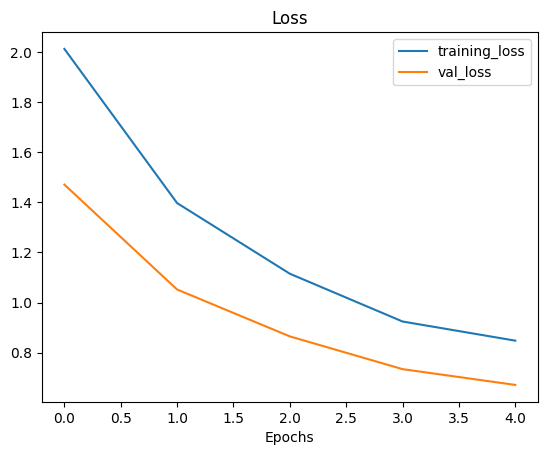

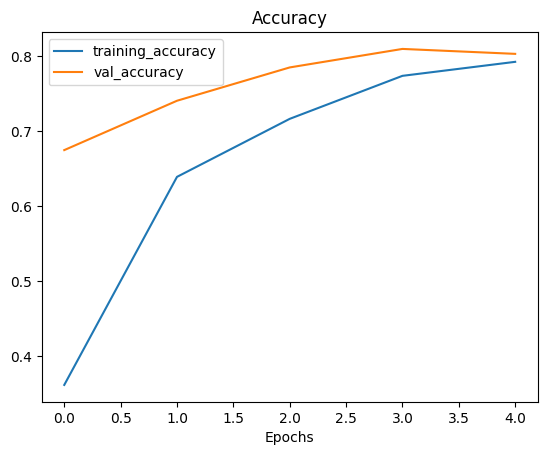

In [31]:
# How do the model with 1% of the data and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

### Model 2: feature extraction transfer learning with 10% of the data

In [38]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [39]:
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [45]:
# Batch normalization??? 
tf.random.set_seed(42)
# Create model 2 with data augmentation build in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
], name="data_preprocessing")

# Setup the imput shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the imputs and outputs
imputs = layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x = base_model(x, training=False)  #pass augmented images to base model but keep it in inference mode
x = layers.GlobalAveragePooling2D(name="global_average_pooled_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2_percent = model_2.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240722-211017
Epoch 1/5
24/24 [==============================] - 7s 147ms/step - loss: 1.9548 - accuracy: 0.3747 - val_loss: 1.3985 - val_accuracy: 0.6743
Epoch 2/5
24/24 [==============================] - 3s 119ms/step - loss: 1.2737 - accuracy: 0.7067 - val_loss: 0.9874 - val_accuracy: 0.7763
Epoch 3/5
24/24 [==============================] - 3s 123ms/step - loss: 1.0083 - accuracy: 0.7547 - val_loss: 0.7743 - val_accuracy: 0.8207
Epoch 4/5
24/24 [==============================] - 3s 119ms/step - loss: 0.8179 - accuracy: 0.8013 - val_loss: 0.6694 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 3s 122ms/step - loss: 0.7153 - accuracy: 0.8200 - val_loss: 0.6008 - val_accuracy: 0.8520


In [52]:
## Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=0)

In [56]:
tf.random.set_seed(42)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240722-213004


Epoch 1/5


24/24 [==============================] - 7s 149ms/step - loss: 0.2381 - accuracy: 0.9507 - val_loss: 0.3979 - val_accuracy: 0.8783
Epoch 2/5
24/24 [==============================] - 3s 133ms/step - loss: 0.2201 - accuracy: 0.9533 - val_loss: 0.3755 - val_accuracy: 0.8849
Epoch 3/5
24/24 [==============================] - 3s 135ms/step - loss: 0.2115 - accuracy: 0.9573 - val_loss: 0.3564 - val_accuracy: 0.8947
Epoch 4/5
24/24 [==============================] - 3s 120ms/step - loss: 0.2187 - accuracy: 0.9573 - val_loss: 0.3658 - val_accuracy: 0.8865
Epoch 5/5
24/24 [==============================] - 3s 123ms/step - loss: 0.1799 - accuracy: 0.9667 - val_loss: 0.3868 - val_accuracy: 0.8750


In [54]:
model_0.evaluate(test_data)

79/79 [==============================] - 2s 21ms/step - loss: 0.5623 - accuracy: 0.8632


[0.5622533559799194, 0.8632000088691711]

In [58]:
result_model_2 = model_2.evaluate(test_data)

79/79 [==============================] - 3s 27ms/step - loss: 0.4083 - accuracy: 0.8692


In [61]:
# Loading in checkpoited weights
model_2.load_weights(checkpoint_path)
loaded_weight_model_2 = model_2.evaluate(test_data)

79/79 [==============================] - 3s 27ms/step - loss: 0.4033 - accuracy: 0.8760
